In [1]:
from scipy.optimize import curve_fit
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle
from tools import *

In [36]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.background import Background2D, MedianBackground
from photutils.datasets import make_100gaussians_image
from photutils.segmentation import detect_sources
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

# Generate some synthetic data

In [37]:
data = make_100gaussians_image()

In [57]:
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

threshold = 2 * bkg.background_rms # threshold for detection


kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

MedianBackground(sigma_clip=None)

# Detect the different objects using the BACKGROUND-SUBTRACTED DATA

In [60]:
segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 84
labels: [ 1  2  3  4  5 ... 80 81 82 83 84]


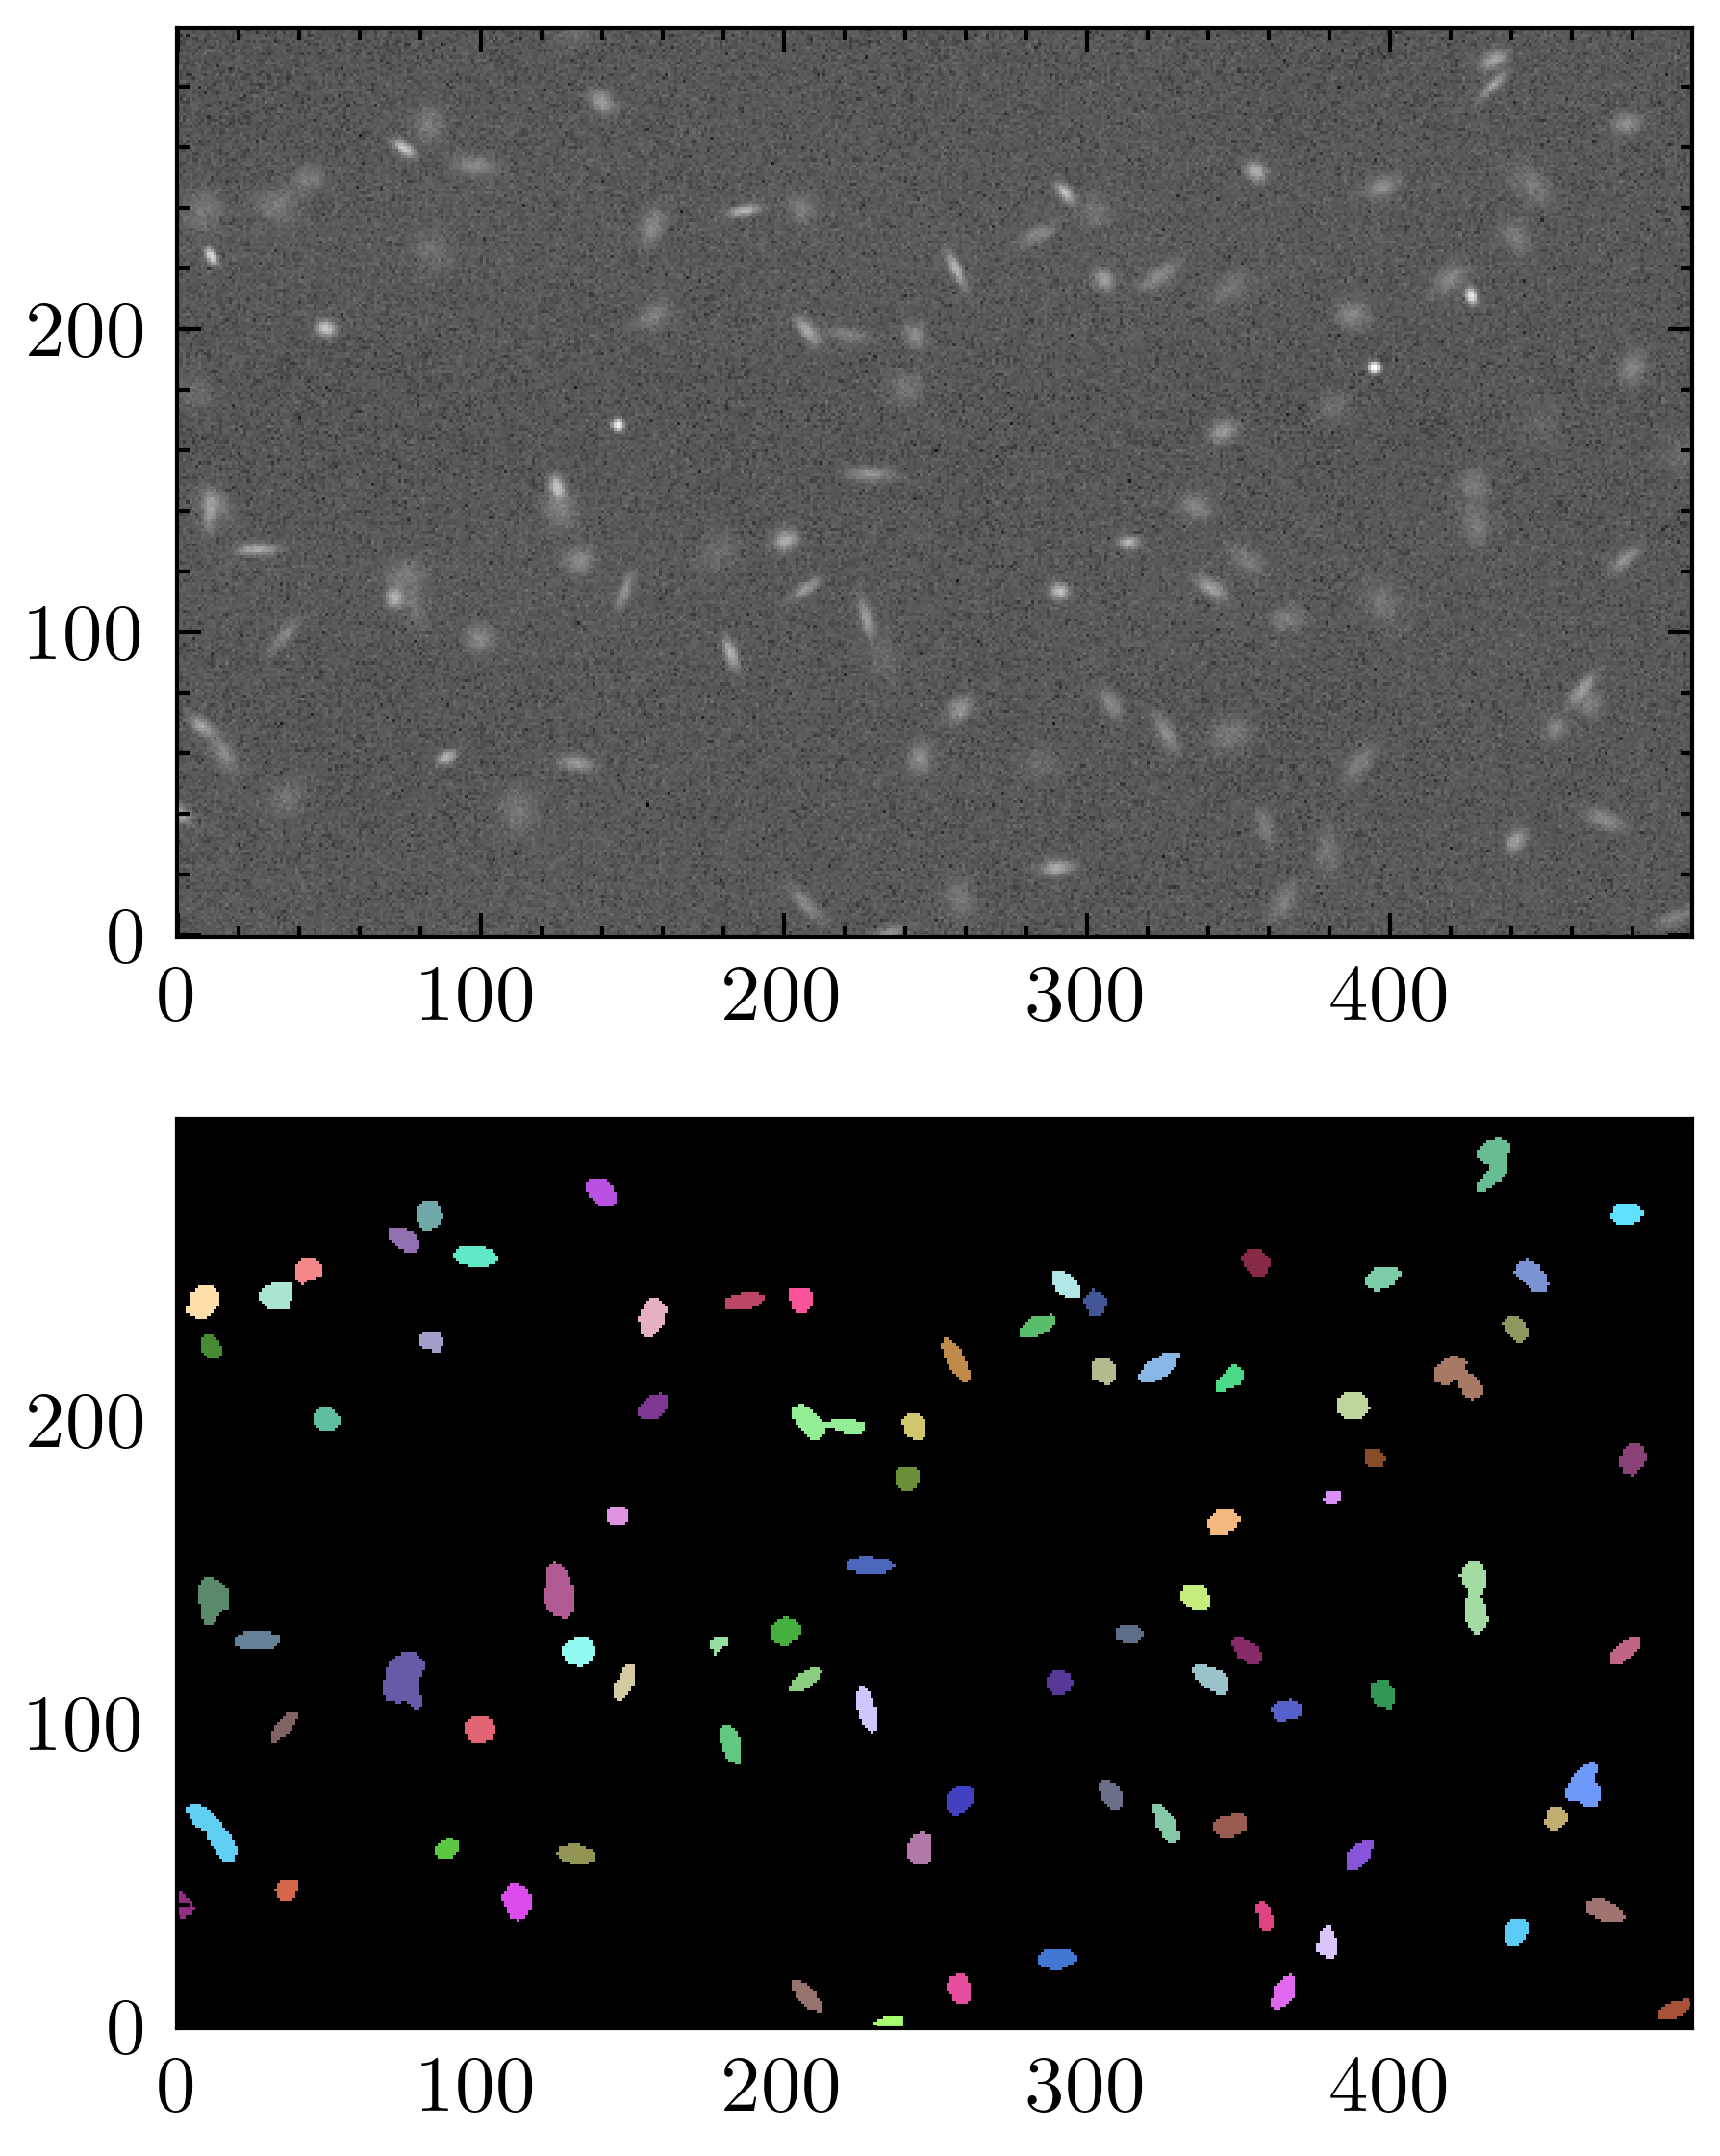

In [61]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5*1.5, 3*1.5), dpi = 600)
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')


# De-blend to avoid missing overlapped objects

In [62]:
from photutils.segmentation import deblend_sources

# contrast  = 0 corresponds to max deblending
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=True)

Deblending:   0%|          | 0/84 [00:00<?, ?it/s]

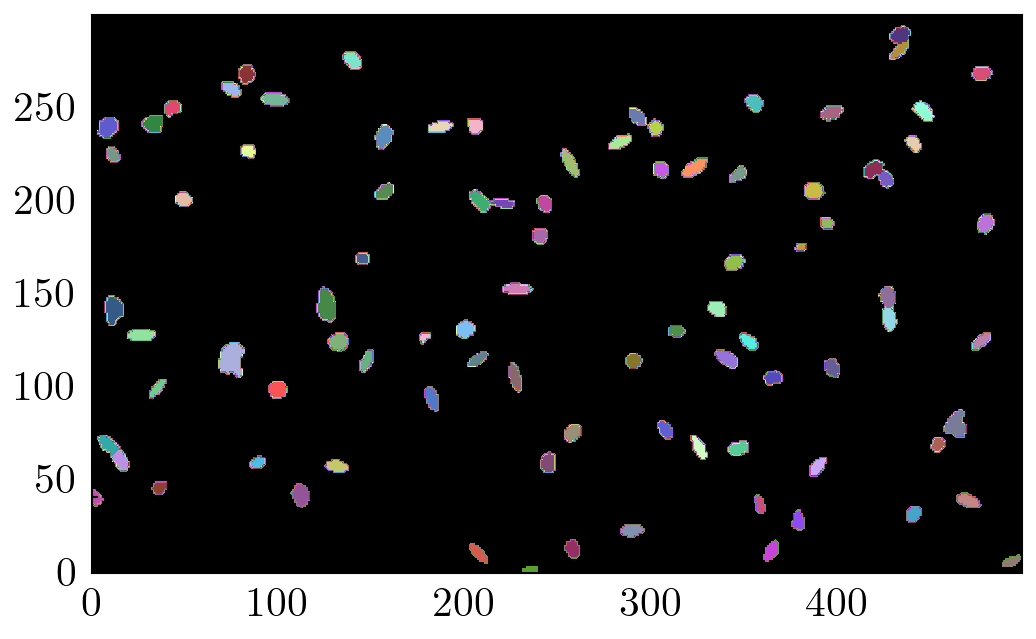

In [67]:
plt.figure(dpi=300)
plt.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap)

# Cataloging 

In [69]:
from photutils.segmentation import SourceCatalog
# Input the detected objects and the background-subtracted data
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 89
labels: [ 1  2  3  4  5 ... 85 86 87 88 89]


In [71]:
# This table contains the centroid coordinates and the flux 
tbl = cat.to_table()

#keyword: tbl['kron_flux'], tbl['xcentroid'], tbl['ycentroid']

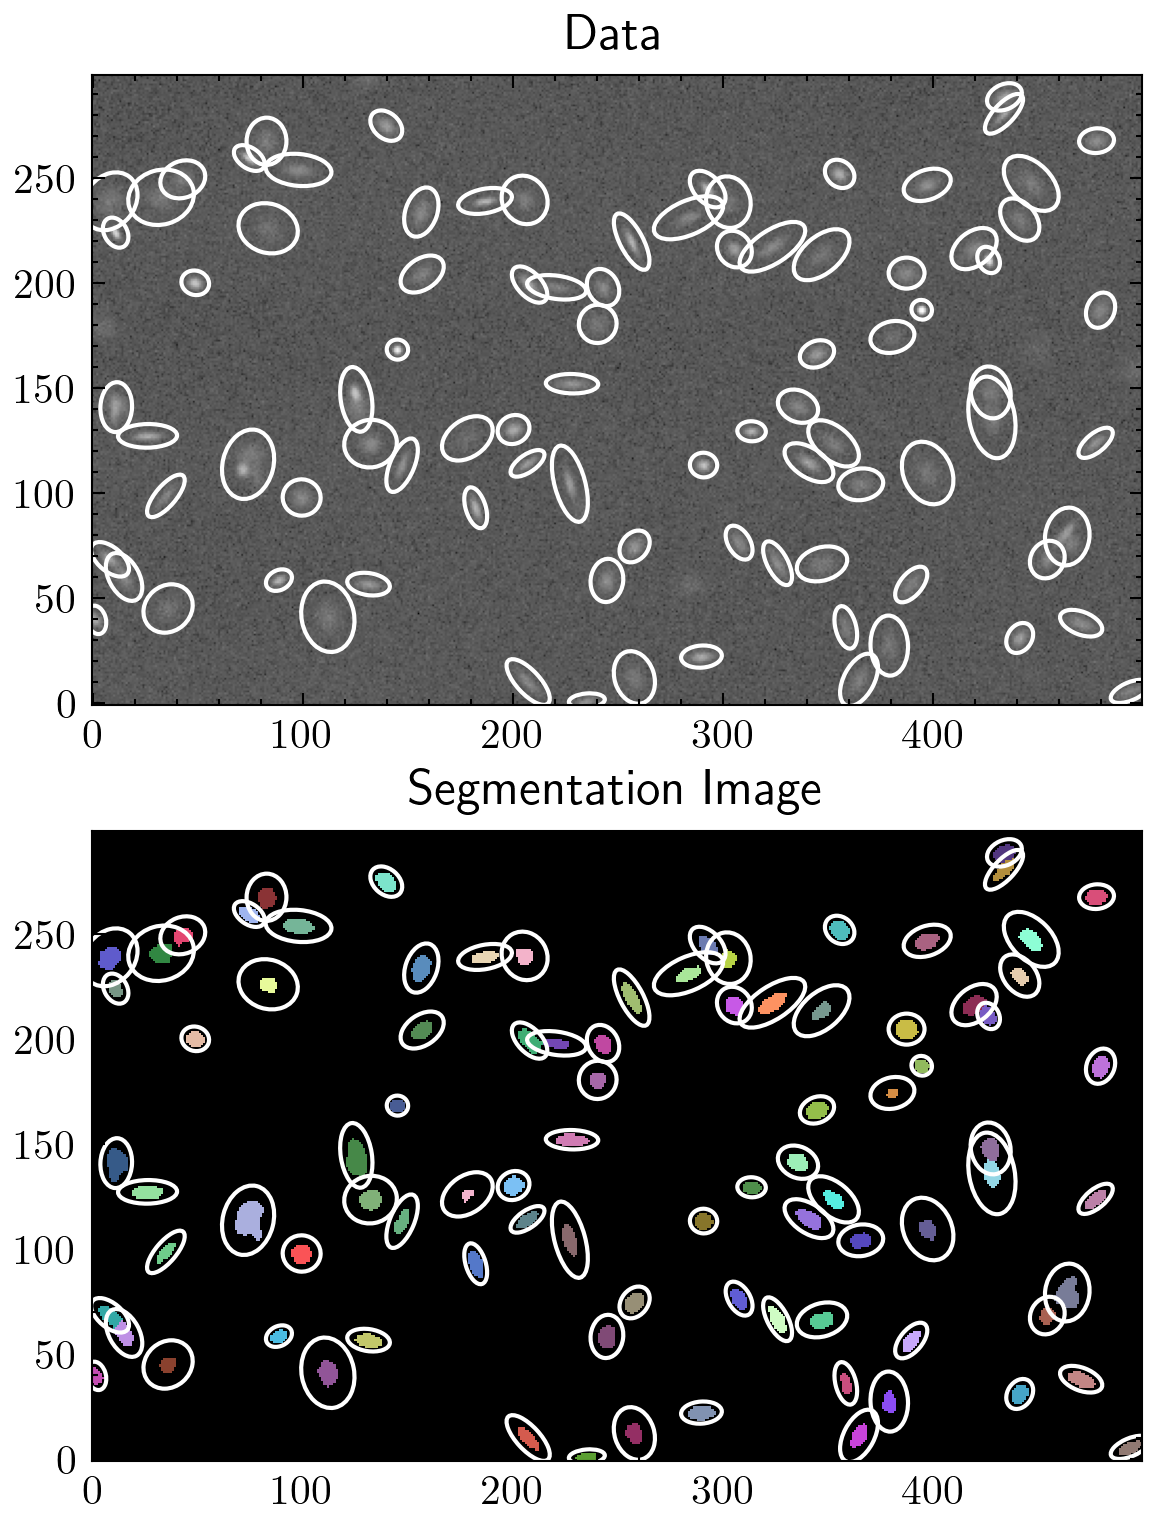

In [80]:
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5*2, 3*2), dpi = 300)
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
cat.plot_kron_apertures(ax=ax1, color='white', lw=1)
cat.plot_kron_apertures(ax=ax2, color='white', lw=1)